In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re
from shapely.geometry import MultiPolygon, Polygon, Point
from sklearn.cluster import KMeans
from geopy.distance import distance
from ast import literal_eval
import math 
from geopy.distance import distance
import pyproj
import ast
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
def plot_data(df, title):
    
    # Separate x and y values from the coordinate tuples and get masses of each point
    x_values = [row['Biomass location'][0] for _, row in df.iterrows()]
    y_values = [row['Biomass location'][1] for _, row in df.iterrows()]
    mass_values = df['Mass'].values

    # To plot the coordinates in WGS84-system
    
    # Define the WGS84 and EUREF-FIN coordinate systems
    wgs84 = pyproj.CRS('EPSG:4326')
    euref_fin = pyproj.CRS('EPSG:3067')
    
    # Transform the location to WGS84 coordinates
    transformer = pyproj.Transformer.from_crs(euref_fin, wgs84, always_xy=True)
    x_values, y_values = transformer.transform(x_values,y_values)
    
    # Plot the data with the colors based on mass
    fig, ax = plt.subplots(figsize=(8, 8))
    sc = ax.scatter(x_values, y_values, c=mass_values, cmap='viridis', s=100)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.title(' '.join(title.split(' ')[:4]) + '\n' + ' '.join(title.split(' ')[4:]), fontsize=16)
    plt.tick_params(labelsize=12)
    
    # Add a colorbar to show the mass values
    cbar = plt.colorbar(sc)
    cbar.ax.set_ylabel('Mass (tonns)', fontsize=14)
    
    path = './pdfs/Biomasses/'
    
    if 'within the given radius' in title:
        path = './pdfs/Biomasses within the given radius to the biogas facility/'
    
    fig.savefig(path + title+'.pdf')
    
    plt.show()


In [3]:
def plot_clusters(df,weighted_avg_centroids,sum_cluster_masses,pdfname):
    
    masses_in_truck_capacity = np.array(sum_cluster_masses) / 45
    
    # Set up a colormap to color the centroids based on their sum of masses
    cmap = plt.get_cmap('Reds')
    norm = mcolors.LogNorm(vmin=np.array(masses_in_truck_capacity).min(), vmax=np.array(masses_in_truck_capacity).max())
    #norm = plt.Normalize(np.array(masses_in_truck_capacity).min(), np.array(masses_in_truck_capacity).max())
    fig, ax = plt.subplots(figsize=(10,10))

    locations = df['Biomass location'].tolist()
    locations = np.array(locations)
    centroids = np.array(weighted_avg_centroids)
    
    # To plot the coordinates in WGS84-system,
    # define the WGS84 and EUREF-FIN coordinate systems
    wgs84 = pyproj.CRS('EPSG:4326')
    euref_fin = pyproj.CRS('EPSG:3067')
    
    # Transform the location to WGS84 coordinates
    transformer = pyproj.Transformer.from_crs(euref_fin, wgs84, always_xy=True)
    x_values, y_values = transformer.transform(locations[:, 0],locations[:, 1])
    x_centroids, y_centroids = transformer.transform(centroids[:, 0],centroids[:, 1])

    # Plotting the data with the centroids

    # scatter plot of data points and their clusters
    plt.scatter(x_values, y_values, c=df['Cluster'])

    # scatter plot of cluster centroids colored by their sum of masses
    plt.scatter(x_centroids, y_centroids, marker='.', s=200, linewidths=3, c=masses_in_truck_capacity, cmap=cmap, norm=norm)

    # Add a colorbar to show the logarithmic scale colormap legend
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Masses in truckloads (45 tons)')
    cbar.set_ticks([1, 10, 100, 1000])  # Customize the ticks on the colorbar
    
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.title('Pickup sites for the file '+' '.join(filename.split(' ')[:4]) + '\n' + ' '.join(filename.split(' ')[4:]), fontsize=16)

    path = './pdfs/Raw pickup sites/'

    if 'Thinned' in pdfname:
        path = './pdfs/Thinned out pickup sites/'
    
    fig.savefig(path + pdfname +filename+'.pdf')
    plt.show()

In [4]:
def load_and_process_data(filename):
    # Read the CSV file and specify the data types of the columns
    dtypes = {'Area': str}
    df = pd.read_csv(filename, header=0, sep=';', dtype=dtypes)

    # Replace characters in the Area column and split it into separate columns
    replacements = {'(': '', ')': '', 'MULTIPOLYGON': ''}
    for index1, row in df.iterrows():
        input_string = str(df['Area'][index1])
        for old, new in replacements.items():
            input_string = input_string.replace(old, new)
        coordinates = input_string.split(',')
        for index2, coordinate in enumerate(coordinates):
            df.loc[index1,'Coordinate '+ str(index2)]=coordinate

    # Calculate the mean points of biomass potentials and replace the coordinates with them
    df2 = df[['Coordinate 0','Coordinate 1','Coordinate 2','Coordinate 3']]
    df2 = df2.apply(lambda row: tuple(map(lambda x: np.sum(x)/len(x), zip(*[map(float, str(c).split()) for c in row]))), axis=1)
    df['Biomass location'] = df2

    # Clean the dataframe
    df = df.loc[:, ['Mass','Biomass location']]
    mask = df['Biomass location'].apply(is_2d_tuple)
    df = df[mask]
    
    return df


In [5]:
def clean_data(df,radius,facilityloc):

    # Clean the data (df) from the rows that are further away than the assumed maximum distance (radius)
    # from the biogas facility locations (facilityloc). 

    # Check input parameters
    if not isinstance(facilityloc, tuple) or len(facilityloc) != 2 or \
       not all(isinstance(x, (int, float)) for x in facilityloc):
        raise ValueError('facilityloc must be a tuple with two numeric elements')

    # Define the WGS84 and EUREF-FIN coordinate systems
    wgs84 = pyproj.CRS('EPSG:4326')
    euref_fin = pyproj.CRS('EPSG:3067')
    
    # Transform the facility location to EUREF-FIN coordinates
    transformer = pyproj.Transformer.from_crs(wgs84, euref_fin, always_xy=True)
    facility_euref_x, facility_euref_y = transformer.transform(facilityloc[1], facilityloc[0])
    facility_loc = (facility_euref_x, facility_euref_y)
 
    
    # Calculate the distances
    distances = df['Biomass location'].apply(lambda loc: math.sqrt(pow(facility_loc[0]-loc[0],2)+pow(facility_loc[1]-loc[1],2))/1000)

    # Filter the data
    df = df.loc[distances <= radius].reset_index(drop=True)
    
    # Remove zero masses from data
    df = df.loc[(df != 0).all(axis=1)]

    return df

In [6]:
def df_cluster_masses_and_locations(df):

    # Getting masses and locations for each cluster

    cluster_masses = [[] for _ in range(len(df['Cluster'].unique()))]
    cluster_locations = [[] for _ in range(len(df['Cluster'].unique()))]

    for index, row in df.iterrows():
        cluster_masses[row['Cluster']].append(row['Mass'])
        cluster_locations[row['Cluster']].append(row['Biomass location'])

    return cluster_masses, cluster_locations

In [7]:
def cluster_sums_and_weight_avg_centroids(df,cluster_masses,cluster_locations):
    # Calculate the weighted average centroid for dataframe's clusters:

    weighted_avg_centroids = []
    sum_cluster_masses = []

    for i in range(len(df['Cluster'].unique())):
        sum_x = np.sum([mass * loc[0] for mass, loc in zip(cluster_masses[i], cluster_locations[i])])
        sum_y = np.sum([mass * loc[1] for mass, loc in zip(cluster_masses[i], cluster_locations[i])])
        weighted_avg_centroids.append((sum_x / np.sum(cluster_masses[i]), sum_y / np.sum(cluster_masses[i])))
        sum_cluster_masses.append(np.sum(cluster_masses[i]))

    return weighted_avg_centroids, sum_cluster_masses

In [8]:
def is_2d_tuple(val):
    
    # Check whether val given as parameter is in expected form of tuple. is used by load_and_process data.
    
    return isinstance(val, tuple) and len(val) == 2 and all(isinstance(x, (int, float)) for x in val)

In [9]:
facility_loc = None 
greatest_distance = None

def set_facility_loc_and_rad():
    global facility_loc
    global greatest_distance  
    user_input = input("Give the coordinates of facility in inspection as a tuple: ")
    trimmed_input = user_input.strip("())")
    coordinates = trimmed_input.split(",")
    coordinates = [float(x) for x in coordinates]
    facility_loc = tuple(coordinates)
    greatest_distance = int(input("Give greatest distance of what biomasses are included: "))

In [10]:
def thin_clusters(df,tire_thickness,tires,cluster_divisor_coefficient,facility_loc):
    
    # Define the WGS84 and EUREF-FIN coordinate systems
    wgs84 = pyproj.CRS('EPSG:4326')
    euref_fin = pyproj.CRS('EPSG:3067')
    
    # Transform the facility location to EUREF-FIN coordinates
    transformer = pyproj.Transformer.from_crs(wgs84, euref_fin, always_xy=True)
    facility_euref_x, facility_euref_y = transformer.transform(facility_loc[1], facility_loc[0])
    facility_loc = (facility_euref_x, facility_euref_y)
    
    # Calculate the distances
    distances = df['Biomass location'].apply(lambda loc: math.sqrt(pow(facility_loc[0]-loc[0],2)+pow(facility_loc[1]-loc[1],2))/1000)
    #i_values = {}  # Create an empty dictionary to store the separated dataframe names and their values
    i_values = [None]*tires
    
    for i in range(tires,0,-1): # Reversed looping for handling the tires in a smarter way
        
        # Reordering the data to subsets of tires
        i_values[tires-i] = df[(tire_thickness*(i-1) <= distances) & (distances <= tire_thickness*i)]  # Assign the filtered data to the corresponding tire

        # Coordinates with mass coefficients of a data subset 
        coords = i_values[tires-i]['LocationWithMassCoefficient'].explode().tolist()

        LocationMassCoords = [(coords[i], coords[i+1]) for i in range(0, len(coords)-1, 2)]
        LocationMassCoords = np.array(LocationMassCoords)

        # CLustering the data of a subset with k-value defined by cluster_divisor_coefficient. Thinning the cluster-areas from 
        # greater distance. Saving new clusters to ThinnedCLusters columns
        previous_kluster_amount = len(i_values[tires-i]['Cluster'].unique()) # NOTE: IN ORIGINAL DATA, ONE CLUSTER MAY BE LOCATED TO MULTIPLE TIRE
                                                                             # THIS SHOULD BE TAKEN IN NOTICE IN DECIDING cluster_divisor_coefficient     
        kmeans = KMeans(n_clusters=int(previous_kluster_amount*pow(cluster_divisor_coefficient,i-1)),n_init='auto')
        kmeans.fit(LocationMassCoords)

        i_values[tires-i]['Cluster'] = kmeans.predict(i_values[tires-i]['Biomass location'].tolist())

    return i_values    

In [11]:
def unite_dataframes_of_thinned_cluster_areas(dfs):

    # Assuming your dataframes are stored in a list called "dfs"
    
    for i, df in enumerate(dfs):
        if i == 0:
            combined_df = df
            continue
        
        clustersAdded = int(len(combined_df['Cluster'].unique()))
        
        df['Cluster'] = df['Cluster']+clustersAdded
        
        combined_df = pd.concat([combined_df,df])
        
    return combined_df

In [12]:
def cluster_biomasses_with_KMeans(df,k):
    
    # To duplicate the coordinate points based on their masses to consider
    # the geographical distribution of masses in clustering.
    
    df['MassCoefficient'] = df['Mass'].apply(round).astype(int).clip(lower=1)
    df['LocationWithMassCoefficient'] = df['Biomass location'] * df['MassCoefficient']
    coords = df['LocationWithMassCoefficient'].explode().tolist()
    LocationMassCoords = [(coords[i], coords[i+1]) for i in range(0, len(coords)-1, 2)]
    LocationMassCoords = np.array(LocationMassCoords)    

    # fitting the mass-distribution fixed data with KMeans
    
    kmeans = KMeans(n_clusters=k,n_init='auto')
    kmeans.fit(LocationMassCoords)
    
    locations = df['Biomass location'].tolist()
    locations = np.array(locations)

    # Making predictions of cluster for each coordinate point 
    df['Cluster'] = kmeans.predict(locations)
    
    return df, kmeans

In [13]:
def euref_fin_to_lon_lat(row):
    
    # Simple function to convert EUREF-FIN coordinates to lon-lat
    
    etrs_tm35fin = pyproj.Proj("+proj=utm +zone=35 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    lon, lat = etrs_tm35fin(row['ClusterLocations'][0], row['ClusterLocations'][1], inverse=True)
    return pd.Series({'lon': lon, 'lat': lat})


In [14]:
def toGeoJSONs(centroids,masses):

    # Transfers and saves clusters into a geojson format. 
    df = pd.DataFrame({'ClusterLocations': centroids, 'Clustermasses': masses}, index=range(1, len(centroids)+1))
    
    df[['lon','lat']] = df.apply(euref_fin_to_lon_lat,axis=1)

    geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    gdf = gdf.drop('ClusterLocations',axis=1) 

    ## save the GeoDataFrame to a GeoJSON file
    path = './geojsons/'
    gdf.to_file(path + file+'.geojson', driver='GeoJSON')

In [34]:
filename = input("Enter biomassdata filename: ") + '.csv'
folder = input("Enter the name of the folder where the file is located: ")
path = './datasets/'
set_facility_loc_and_rad()
df = load_and_process_data(path+'/'+folder+'/'+filename)
file = filename.split('.',1)[0]
# Coordinates for Envor's facility: (60.929833, 23.369694)

Enter biomassdata filename: Nautojenkuivalantavarastosta2016
Enter the name of the folder where the file is located: Kuivalannat
Give the coordinates of facility in inspection as a tuple: (60.929833, 23.369694)
Give greatest distance of what biomasses are included: 50


C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, header=0, sep=';', dtype=dtypes)
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ s

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[index1,'Coordinate '+ str(index2)]=coordinate
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\700681997.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

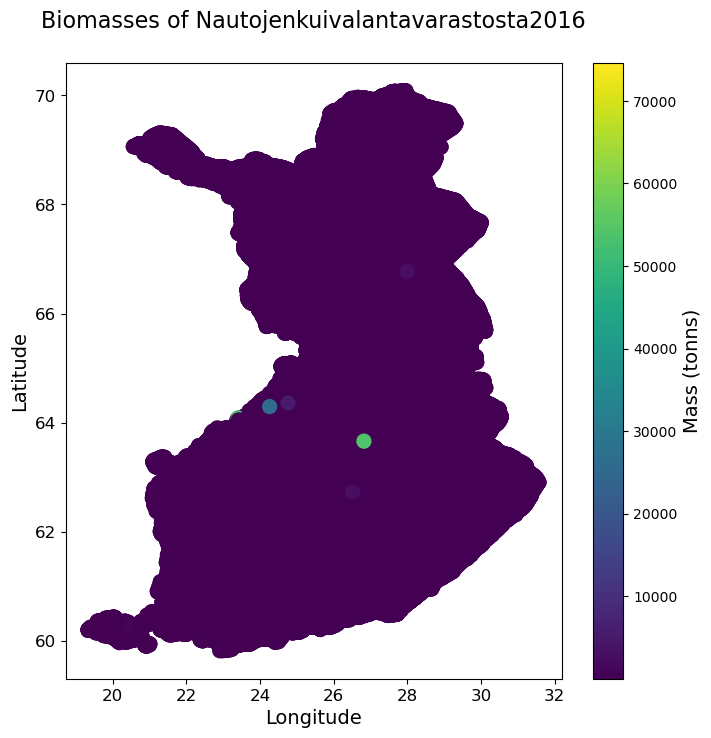

In [35]:
plot_data(df,'Biomasses of ' + file)

In [36]:
df = clean_data(df,greatest_distance,facility_loc)

df

,Mass,Biomass location
0,12.453089,"(315500.0, 6713500.0)"
1,10.627819,"(297500.0, 6716500.0)"
2,10.627819,"(282500.0, 6717500.0)"
3,12.453089,"(317500.0, 6717500.0)"
4,10.627819,"(305500.0, 6718500.0)"
...,...,...
15735,9.605390,"(316500.0, 6804500.0)"
15736,9.605390,"(315500.0, 6804500.0)"
15737,9.605390,"(314500.0, 6805500.0)"
15738,9.605390,"(313500.0, 6806500.0)"


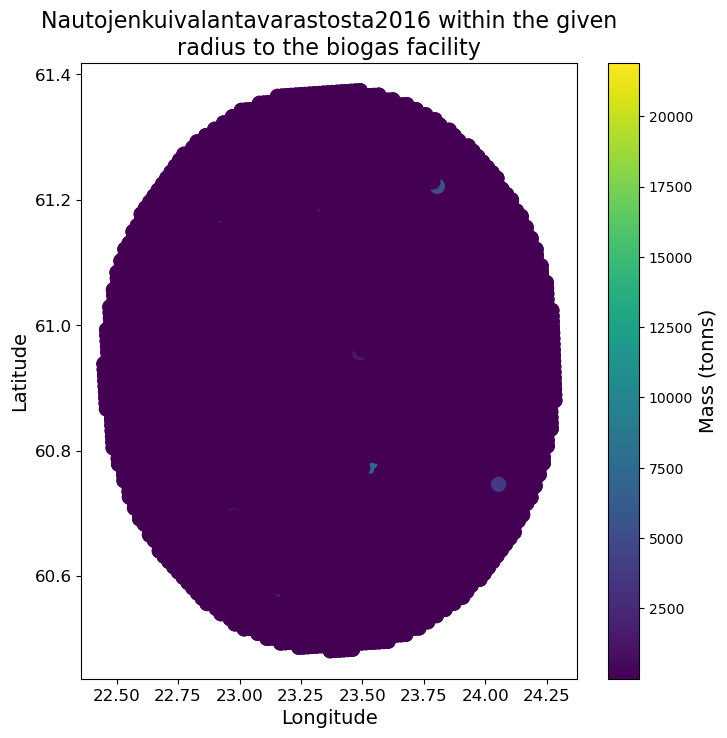

In [37]:
plot_data(df,file+' within the given radius to the biogas facility')

In [38]:
# Tsekkaa paperi GIS-data related route optimization, hierarchical clustering, location
# optimization, and kernel density methods are useful for promoting
# distributed bioenergy plant planning in rural areas
# K. Laasasenahoa*, A. Lensub*, R. Lauhanenc
# and J. Rintalaa

# Clustering the data with K-means. Utilzing the elbow method to decide optimal value for k.
# The basic idea in elbow method is to plot the within-cluster 
# sum of squares (WCSS) against the number of clusters, and choose the number of clusters 
# at the "elbow" point where the rate of decrease in WCSS slows down significantly.

# To be used in consideration of mass distribution. Each coordinate will be multiplied 
# with their MassCoefficient in clustering
# to give more weight to the points with greater mass. 
'''
df['MassCoefficient'] = df['Mass'].apply(round).astype(int).clip(lower=1)
df['LocationWithMassCoefficient'] = df['Biomass location'] * df['MassCoefficient']

coords = df['LocationWithMassCoefficient'].explode().tolist()
LocationMassCoords = [(coords[i], coords[i+1]) for i in range(0, len(coords)-1, 2)]
LocationMassCoords = np.array(LocationMassCoords)

k_vals = list(range(1,100))
wcss = []
labels=[]

for i in k_vals:    
    kmeans = KMeans(n_clusters=i,n_init='auto')
    kmeans.fit(LocationMassCoords)
    wcss.append(kmeans.inertia_)
    labels.append(kmeans.predict(LocationMassCoords))
''' 

"\ndf['MassCoefficient'] = df['Mass'].apply(round).astype(int).clip(lower=1)\ndf['LocationWithMassCoefficient'] = df['Biomass location'] * df['MassCoefficient']\n\ncoords = df['LocationWithMassCoefficient'].explode().tolist()\nLocationMassCoords = [(coords[i], coords[i+1]) for i in range(0, len(coords)-1, 2)]\nLocationMassCoords = np.array(LocationMassCoords)\n\nk_vals = list(range(1,100))\nwcss = []\nlabels=[]\n\nfor i in k_vals:    \n    kmeans = KMeans(n_clusters=i,n_init='auto')\n    kmeans.fit(LocationMassCoords)\n    wcss.append(kmeans.inertia_)\n    labels.append(kmeans.predict(LocationMassCoords))\n"

In [39]:
# Plot the WCSS values against the number of clusters
'''
plt.plot(range(1, 100), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
'''

"\nplt.plot(range(1, 100), wcss)\nplt.title('Elbow Method')\nplt.xlabel('Number of clusters')\nplt.ylabel('WCSS')\nplt.show()\n"

In [40]:
# Based on the graph above, close to optimal and good enough k-values for this datasets is 60.
# Let's plot the data with 60 clusters.
# Plotting the data

# Because of the later trimming data from the clusters far away from the facility, initialize clustering with K=200

#KCLUSTERS = 200

#kmeans = KMeans(n_clusters=KCLUSTERS,n_init='auto')
#kmeans.fit(LocationMassCoords)
#labels = kmeans.predict(LocationMassCoords)
#plt.scatter(LocationMassCoords[:,0],LocationMassCoords[:,1],c=labels)

In [41]:
df, kmeans = cluster_biomasses_with_KMeans(df,200)

In [42]:
df

,Mass,Biomass location,MassCoefficient,LocationWithMassCoefficient,Cluster
0,12.453089,"(315500.0, 6713500.0)",12,"(315500.0, 6713500.0, 315500.0, 6713500.0, 315...",140
1,10.627819,"(297500.0, 6716500.0)",11,"(297500.0, 6716500.0, 297500.0, 6716500.0, 297...",174
2,10.627819,"(282500.0, 6717500.0)",11,"(282500.0, 6717500.0, 282500.0, 6717500.0, 282...",8
3,12.453089,"(317500.0, 6717500.0)",12,"(317500.0, 6717500.0, 317500.0, 6717500.0, 317...",29
4,10.627819,"(305500.0, 6718500.0)",11,"(305500.0, 6718500.0, 305500.0, 6718500.0, 305...",178
...,...,...,...,...,...
15735,9.605390,"(316500.0, 6804500.0)",10,"(316500.0, 6804500.0, 316500.0, 6804500.0, 316...",11
15736,9.605390,"(315500.0, 6804500.0)",10,"(315500.0, 6804500.0, 315500.0, 6804500.0, 315...",114
15737,9.605390,"(314500.0, 6805500.0)",10,"(314500.0, 6805500.0, 314500.0, 6805500.0, 314...",114
15738,9.605390,"(313500.0, 6806500.0)",10,"(313500.0, 6806500.0, 313500.0, 6806500.0, 313...",114


In [43]:
cluster_masses, cluster_locations =  df_cluster_masses_and_locations(df)

In [44]:
weighted_avg_centroids, sum_cluster_masses = cluster_sums_and_weight_avg_centroids(df,cluster_masses, cluster_locations)

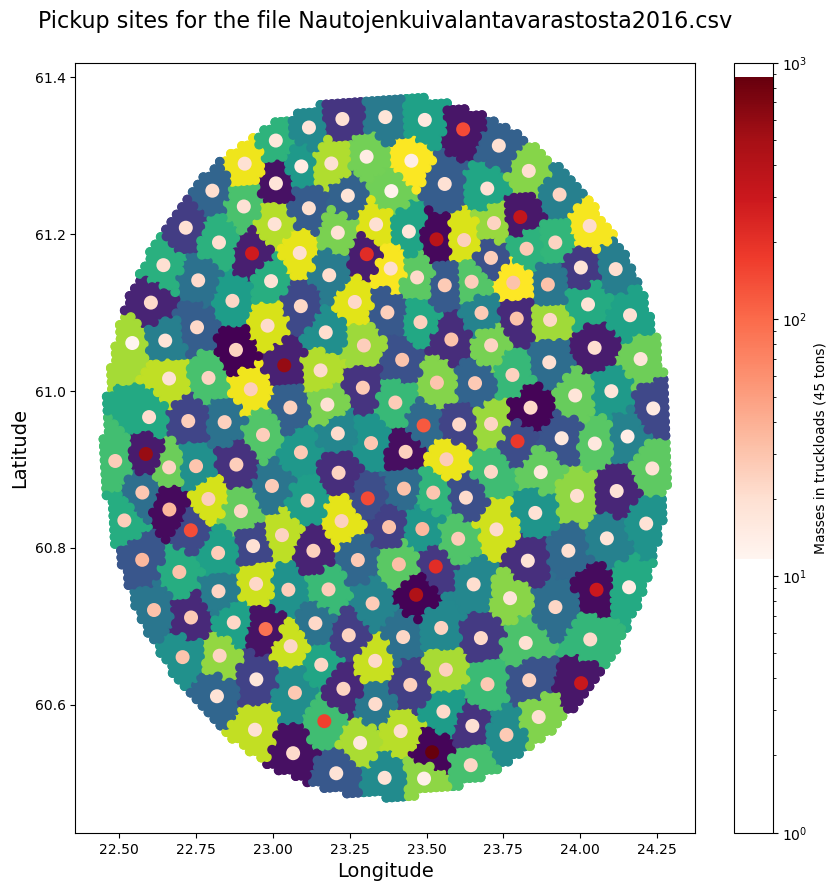

In [45]:
plot_clusters(df,weighted_avg_centroids,sum_cluster_masses,'Raw pickup sites for the file ')

In [46]:
thinned_and_clustered_tires = thin_clusters(df,10,5,0.7,facility_loc)

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\3357369377.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_values[tires-i]['Cluster'] = kmeans.predict(i_values[tires-i]['Biomass location'].tolist())
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\3357369377.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i_values[tires-i]['Cluster'] = kmeans.predict(i_values[tires-i]['Biomass location'].tolist())
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\3357369377.py:35: SettingWithCopyWarning: 
A valu

In [47]:
thinned_area = unite_dataframes_of_thinned_cluster_areas(thinned_and_clustered_tires)

C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\1003140816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = df['Cluster']+clustersAdded
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\1003140816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = df['Cluster']+clustersAdded
C:\Users\K-A-S\AppData\Local\Temp\ipykernel_4556\1003140816.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [48]:
thinned_area

,Mass,Biomass location,MassCoefficient,LocationWithMassCoefficient,Cluster
0,12.453089,"(315500.0, 6713500.0)",12,"(315500.0, 6713500.0, 315500.0, 6713500.0, 315...",1
1,10.627819,"(297500.0, 6716500.0)",11,"(297500.0, 6716500.0, 297500.0, 6716500.0, 297...",6
2,10.627819,"(282500.0, 6717500.0)",11,"(282500.0, 6717500.0, 282500.0, 6717500.0, 282...",18
3,12.453089,"(317500.0, 6717500.0)",12,"(317500.0, 6717500.0, 317500.0, 6717500.0, 317...",13
4,10.627819,"(305500.0, 6718500.0)",11,"(305500.0, 6718500.0, 305500.0, 6718500.0, 305...",1
...,...,...,...,...,...
15617,5.713105,"(295500.0, 6762500.0)",6,"(295500.0, 6762500.0, 295500.0, 6762500.0, 295...",123
15619,5.713105,"(296500.0, 6763500.0)",6,"(296500.0, 6763500.0, 296500.0, 6763500.0, 296...",115
15629,15.301298,"(307500.0, 6766500.0)",15,"(307500.0, 6766500.0, 307500.0, 6766500.0, 307...",122
15632,10.106403,"(299500.0, 6768500.0)",10,"(299500.0, 6768500.0, 299500.0, 6768500.0, 299...",126


In [49]:
thinned_cluster_masses, thinned_cluster_locations =  df_cluster_masses_and_locations(thinned_area)

In [50]:
thinned_weighted_avg_centroids, thinned_sum_cluster_masses = cluster_sums_and_weight_avg_centroids(thinned_area,thinned_cluster_masses, thinned_cluster_locations)

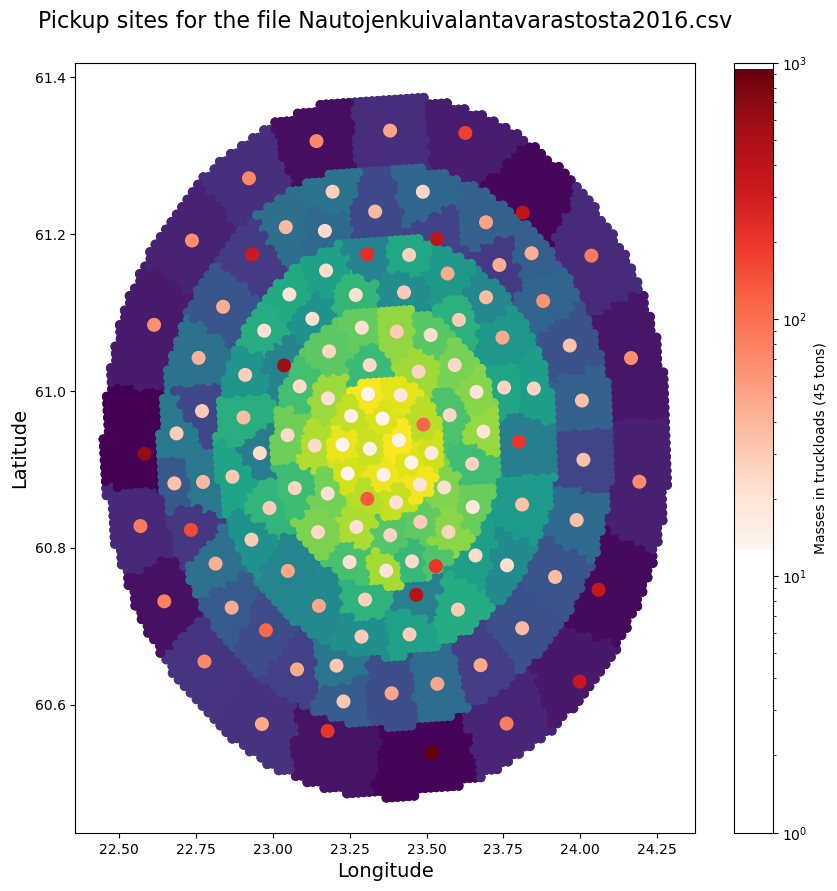

In [51]:
plot_clusters(thinned_area,thinned_weighted_avg_centroids, thinned_sum_cluster_masses,'Thinned out pickup sites for the file ')

In [52]:
toGeoJSONs(thinned_weighted_avg_centroids,thinned_sum_cluster_masses)

In [ ]:
def main():
    
    filename = input("Enter biomassdata filename: ") + '.csv'
    folder = input("Enter the name of the folder where the file is located: ")
    path = './datasets/'
    set_facility_loc_and_rad()
    df = load_and_process_data(path+'/'+folder+'/'+filename)
    file = filename.split('.',1)[0]
    # Coordinates for Envor's facility: (60.929833, 23.369694)

    plot_data(df,'Biomasses of ' + file)

    df = clean_data(df,greatest_distance,facility_loc)

    plot_data(df,file+' within the given radius to the biogas facility')

    df, kmeans = cluster_biomasses_with_KMeans(df,200)

    cluster_masses, cluster_locations =  df_cluster_masses_and_locations(df)

    weighted_avg_centroids, sum_cluster_masses = cluster_sums_and_weight_avg_centroids(df,cluster_masses, cluster_locations)

    plot_clusters(df,weighted_avg_centroids,sum_cluster_masses,'Raw pickup sites for the file ')

    thinned_and_clustered_tires = thin_clusters(df,10,5,0.7,facility_loc)

    thinned_area = unite_dataframes_of_thinned_cluster_areas(thinned_and_clustered_tires)

    thinned_cluster_masses, thinned_cluster_locations =  df_cluster_masses_and_locations(thinned_area)

    thinned_weighted_avg_centroids, thinned_sum_cluster_masses = cluster_sums_and_weight_avg_centroids(thinned_area,thinned_cluster_masses, thinned_cluster_locations)

    plot_clusters(thinned_area,thinned_weighted_avg_centroids, thinned_sum_cluster_masses,'Thinned out pickup sites for the file ')

    toGeoJSONs(thinned_weighted_avg_centroids,thinned_sum_cluster_masses)

In [53]:
main()

NameError: name 'main' is not defined